In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sb
import folium
plt.rcParams['figure.figsize'] = (18, 9)

# ETL (extract, transform, load)

## load csv, shp file

In [2]:
#load into main df_csv
df_csv = pd.read_csv('rm_crop_yields_1938_2021.csv')

In [3]:
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25017 entries, 0 to 25016
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          25017 non-null  int64  
 1   RM            25017 non-null  int64  
 2   Winter Wheat  3037 non-null   float64
 3   Canola        14008 non-null  float64
 4   Spring Wheat  24924 non-null  float64
 5   Mustard       4487 non-null   float64
 6   Durum         11581 non-null  float64
 7   Sunflowers    946 non-null    float64
 8   Oats          23913 non-null  float64
 9   Lentils       5515 non-null   float64
 10  Peas          8134 non-null   float64
 11  Barley        24703 non-null  float64
 12  Fall Rye      15847 non-null  float64
 13  Canary Seed   3819 non-null   float64
 14  Spring Rye    805 non-null    float64
 15  Tame Hay      4205 non-null   float64
 16  Flax          20934 non-null  float64
 17  Chickpeas     960 non-null    float64
dtypes: float64(16), int64(2)
m

In [4]:
df_csv.rename(columns={"Winter Wheat": "WinterWheat", "Spring Wheat": "SpringWheat","Fall Rye":"FallRye",\
             "Canary Seed":"CanarySeed","Spring Rye":"SpringRye","Tame Hay":"TameHay"},inplace=True)

In [5]:
#https://saskpulse.com
#https://www.rayglen.com/grain-conversion-calculator/
# (lbs/ac) -> Mustard (50 lbs/bu), Sunflower (30 lbs/bu), Lentils (60 lbs/bu), 
#             Canary Seeed (50 lbs/bu), Chickpeas (60lb/bu)

# Tame Hay (tons/ac)
# All the rest are bushel/acre (bu/ac)
df_csv['Mustard']=df_csv['Mustard']/50
df_csv['Sunflowers']=df_csv['Sunflowers']/30
df_csv['Lentils']=df_csv['Lentils']/60
df_csv['CanarySeed']=df_csv['CanarySeed']/50
df_csv['Chickpeas']=df_csv['Chickpeas']/60

#cannot find conversion for Tame Hay
df_csv.drop(['TameHay'],axis=1,inplace=True)

In [6]:
#load shp data
gdf = gpd.read_file('Rural Municipality.shp')

#drop columns that won't be using
gdf.drop(['PPID','EFFDT','EXPDT','FEATURECD','SHAPE_AREA','SHAPE_LEN'],axis=1,inplace=True)

#rename column to match with main df
gdf.rename(columns=
{   'RMNO': 'RM',
    'RMNM': 'Municipality'
}, inplace=True)

#match data type between df_csv and gdf
gdf['RM']=gdf['RM'].astype('int')
gdf['Municipality']=gdf['Municipality'].astype('string')


In [7]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   RM            298 non-null    int64   
 1   Municipality  298 non-null    string  
 2   geometry      298 non-null    geometry
dtypes: geometry(1), int64(1), string(1)
memory usage: 7.1 KB


# EDA (Extrapolatory Data Analysis)

#### check for unique values

In [8]:
gdf['RM'].unique()
gdf['RM'].nunique()
#298 unique RM

298

#### check for duplicated values

In [9]:
gdf.duplicated().sum()

0

In [10]:
df_describe = df_csv.describe().copy()
df_describe
# Total of 25017 rows
# Year from 1938 to 2021 ~ 84 years
# 299 RM from 1 to 622 
# Spring Wheat, Barley and Oats have the most rows -> more complete data?
# Oats, Winter Wheat, Barley has the most mean -> most yield
# Tame Hay, Spring Rye, Flax have the least mean -> least yield

,Year,RM,WinterWheat,Canola,SpringWheat,Mustard,Durum,Sunflowers,Oats,Lentils,Peas,Barley,FallRye,CanarySeed,SpringRye,Flax,Chickpeas
count,25017.000000,25017.000000,3037.00000,14008.000000,24924.000000,4487.000000,11581.000000,946.000000,23913.000000,5515.000000,8134.000000,24703.000000,15847.000000,3819.000000,805.000000,20934.000000,960.000000
mean,1979.385938,248.957509,38.24350,24.146796,25.778733,16.883719,29.024429,23.087664,47.104433,19.529647,30.971982,38.022104,21.225298,19.902804,7.575776,14.287663,23.467677
std,24.221744,148.829628,12.20715,9.209177,11.153028,5.514007,9.829962,18.525887,21.775369,6.815627,10.223101,16.610425,10.101176,7.084164,12.473814,7.082308,9.660584
min,1938.000000,1.000000,3.00000,0.000000,0.000000,0.712000,0.000000,0.000000,0.000000,0.766667,0.000000,0.000000,0.000000,0.120000,0.000000,0.000000,0.516667
25%,1958.000000,124.000000,30.00000,18.000000,19.000000,13.270000,23.000000,0.000000,33.000000,15.000000,24.300000,26.000000,15.000000,15.140000,0.000000,9.000000,16.666667
50%,1979.000000,247.000000,38.00000,23.000000,25.600000,16.940000,28.200000,26.350000,46.000000,19.433333,31.000000,37.900000,20.000000,20.000000,0.000000,14.000000,22.941667
75%,2000.000000,370.000000,45.50000,29.200000,31.800000,20.018900,34.300000,36.666667,59.000000,23.983333,37.900000,48.750000,26.300000,24.000000,20.000000,19.200000,29.704167
max,2021.000000,622.000000,90.00000,59.500000,198.000000,50.000000,85.370000,80.000000,165.100000,56.850000,86.800000,105.940000,108.000000,54.540000,46.500000,110.000000,90.000000


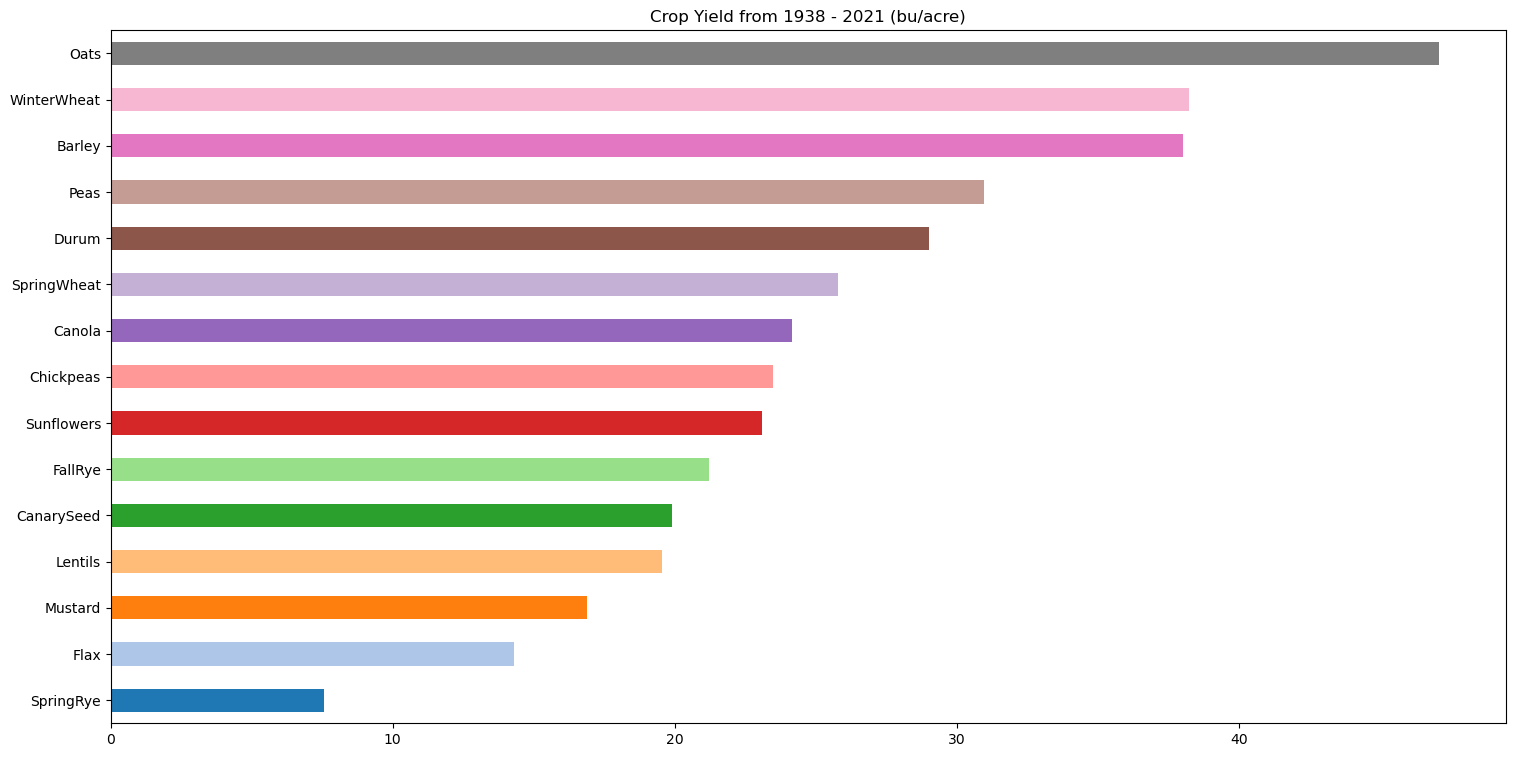

In [11]:
cmap = plt.cm.tab20
colors = cmap(np.arange(len(df_describe.iloc[1, 2:17])) % cmap.N)
fig=df_describe.iloc[1, 2:17].sort_values(axis=0).plot(kind='barh', figsize=(18,9),title='Crop Yield from 1938 - 2021 (bu/acre)',color=colors).get_figure()
fig.savefig('Crop Yield 1938 to 2021.jpg',bbox_inches='tight')

In [12]:
#count unique RM
df_csv['RM'].unique()
df_csv['RM'].nunique()

299

In [13]:
#check for duplicated rows
df_csv.duplicated().sum()

0

In [14]:
#check how many records there are each year
#-->not all have data for all years
temp_df= df_csv.groupby('Year').count()['RM']
temp_df = temp_df[temp_df!=299]
temp_df

Year
1991    298
1992    297
1993    297
1994    297
1995    297
1996    297
1997    297
1998    297
1999    296
2000    296
2001    296
2002    296
2003    296
2004    296
2005    296
2006    296
2007    296
2008    296
2009    293
2010    295
2011    295
2012    295
2013    295
2014    295
2015    295
2016    295
2017    295
2018    295
2019    295
2020    295
2021    295
Name: RM, dtype: int64

In [15]:
#check for RM with less than 84 years of data
temp_df= df_csv.groupby('RM').count()['Year']
temp_df = temp_df[temp_df!=84]
temp_df

RM
132    83
278    71
408    61
521    53
529    54
555    83
Name: Year, dtype: int64

In [16]:
#Municipality with less than 84 years of data

pd.merge(temp_df,gdf,on='RM')

,RM,Year,Municipality,geometry
0,132,83,HILLSBOROUGH,"POLYGON ((445175.620 5573313.600, 445572.880 5..."
1,521,53,DISTRICT OF LAKELAND,"MULTIPOLYGON (((442578.660 5974009.340, 442566..."
2,555,83,BIG RIVER,"POLYGON ((382623.457 5977383.405, 382824.163 5..."


In [17]:
#check for RM not in geodata

temp_df= df_csv.groupby('RM').count().index
temp_df = temp_df[~temp_df.isin(gdf['RM'])]
temp_df

#278 Kutawa, Prairie No. 408, Greenfield No. 529

Int64Index([278, 408, 529], dtype='int64', name='RM')

In [18]:
#check for geodata RM not in main data set

temp_df= df_csv.groupby('RM').count().index
temp_gdf = gdf[~gdf['RM'].isin(temp_df)]
temp_gdf

,RM,Municipality,geometry
179,999,NORTHERN ADMIN DISTRICT,"MULTIPOLYGON (((666659.844 6655115.377, 666876..."
201,998,NORTHERN ADMIN DISTRICT,"MULTIPOLYGON (((443384.000 6596155.000, 442966..."


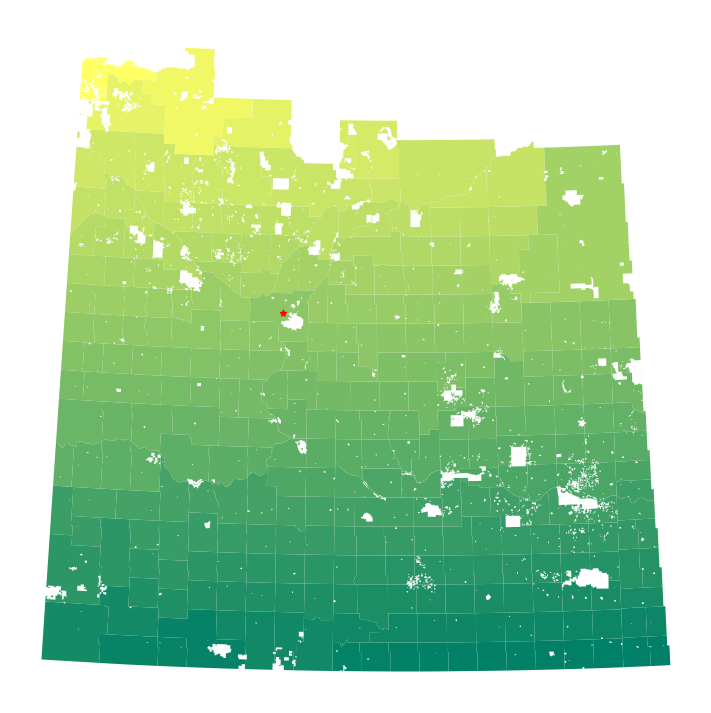

In [19]:
df_one_RM = gdf[gdf['RM']==344].copy()
df_one_RM['geometry'] = df_one_RM['geometry'].centroid

df_one_RM = df_one_RM.to_crs(gdf.crs)
ax = pd.merge(
        gdf,
        pd.DataFrame(df_csv['RM'].unique(),columns = ['RM']),
        on='RM'
        ).plot(column='RM',cmap='summer'
    )
ax.set_axis_off()

df_one_RM.plot(ax=ax,marker='*', color='red', markersize=20);

plt.savefig('RM_MAP.jpg')

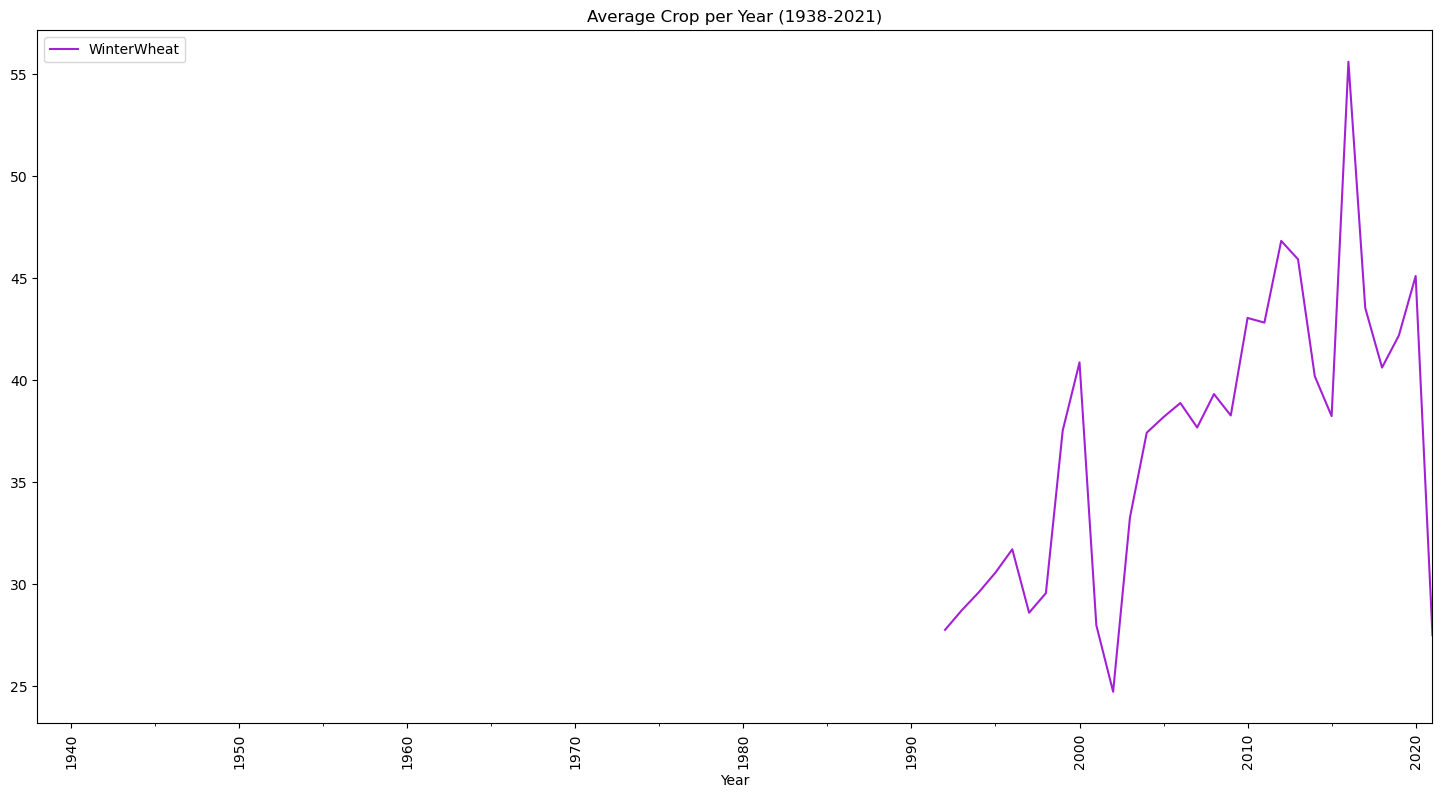

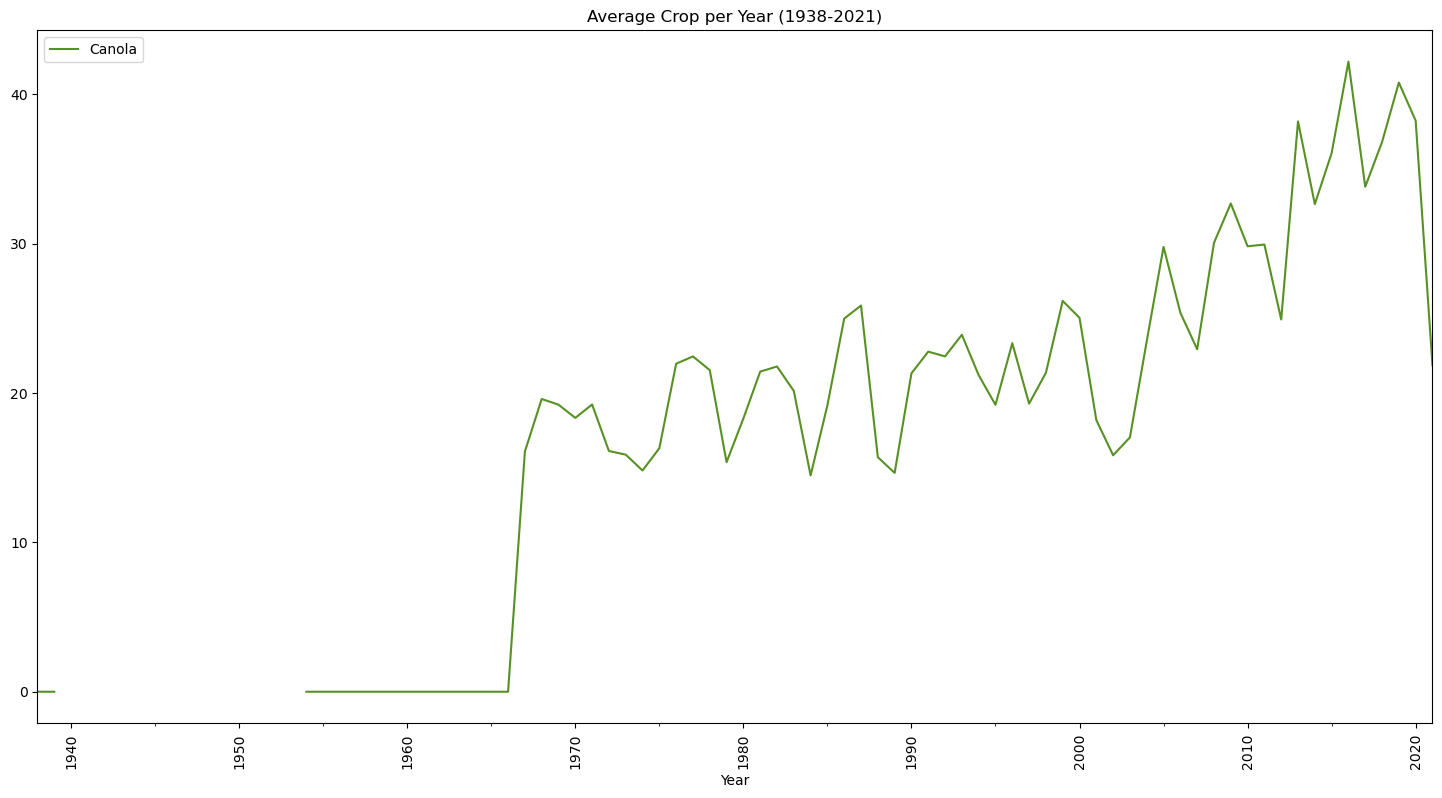

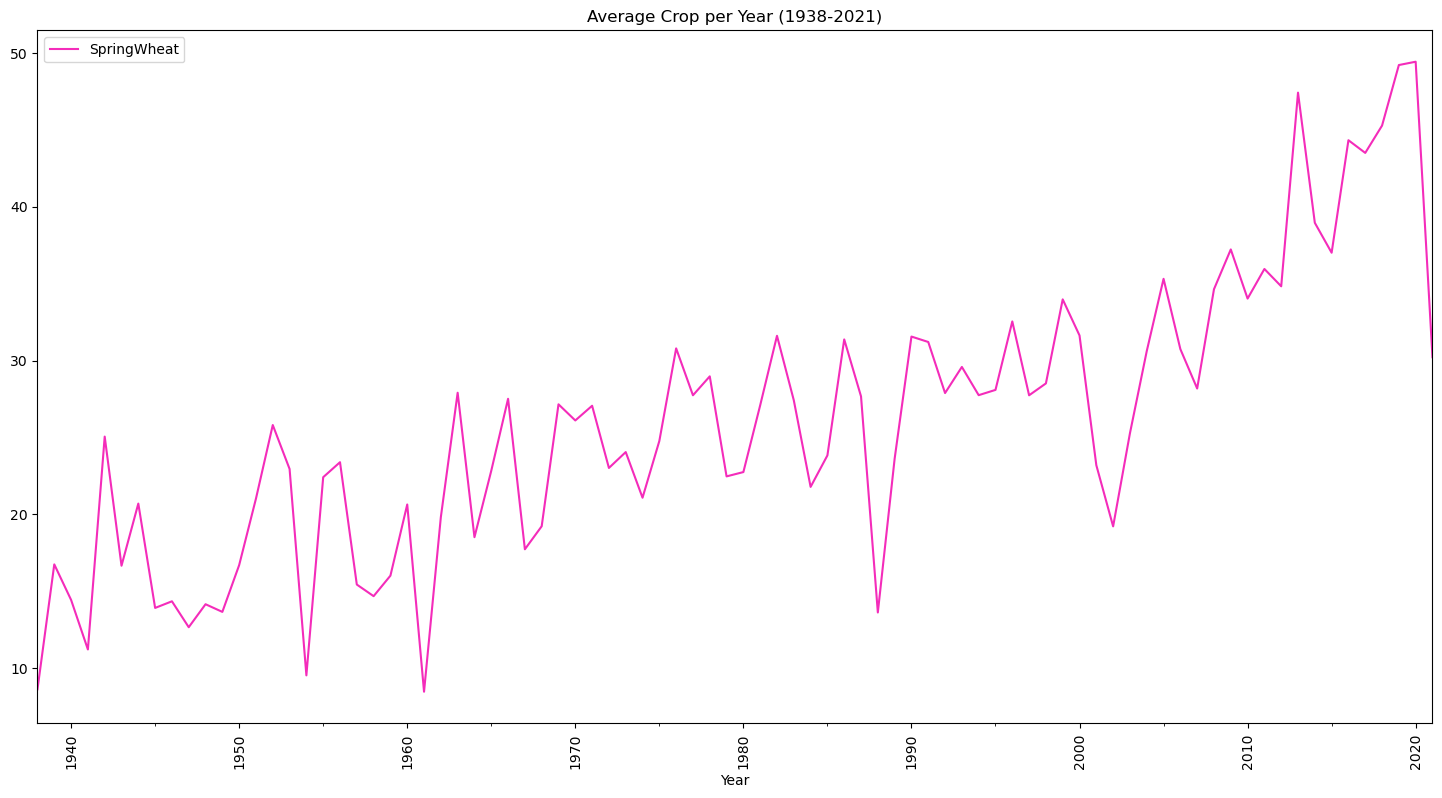

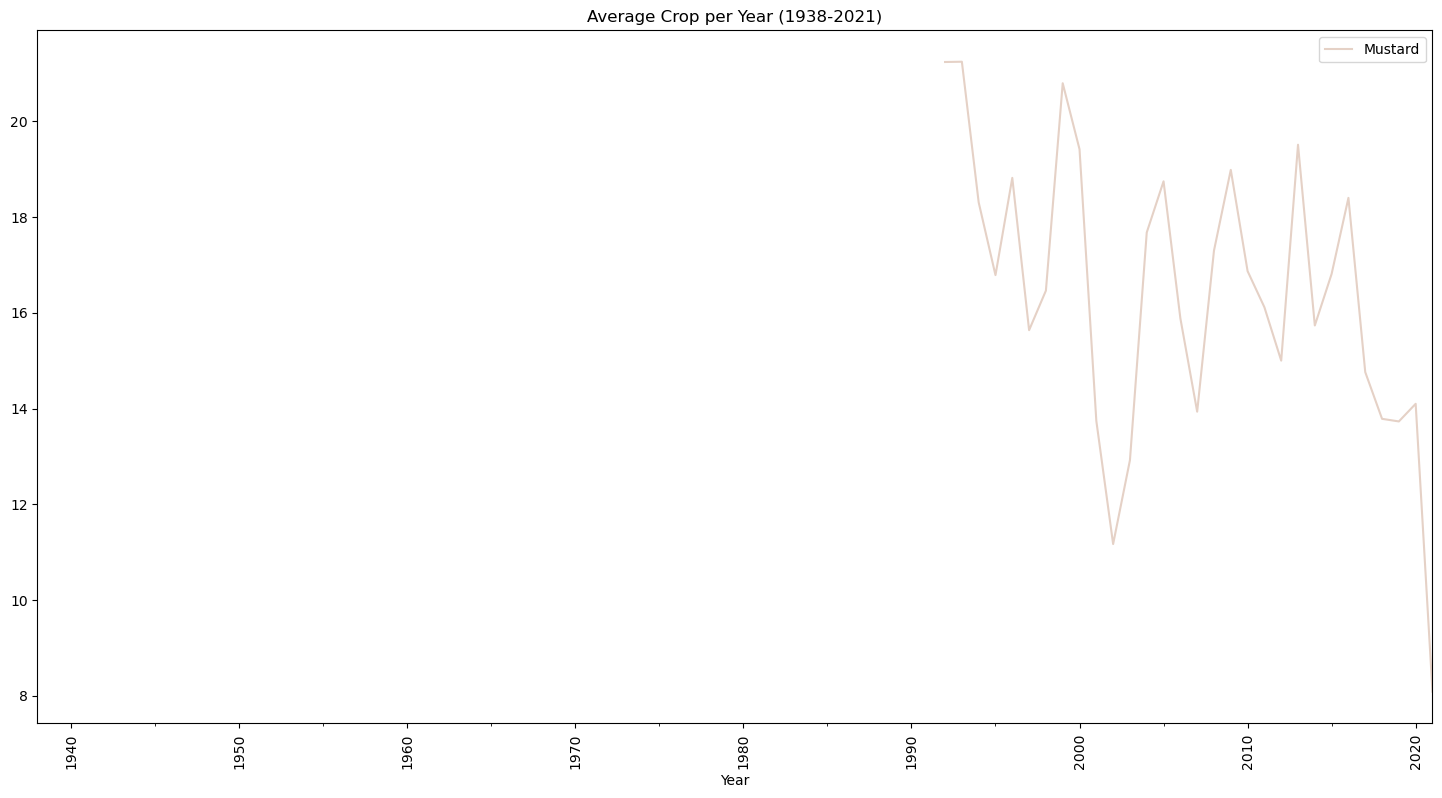

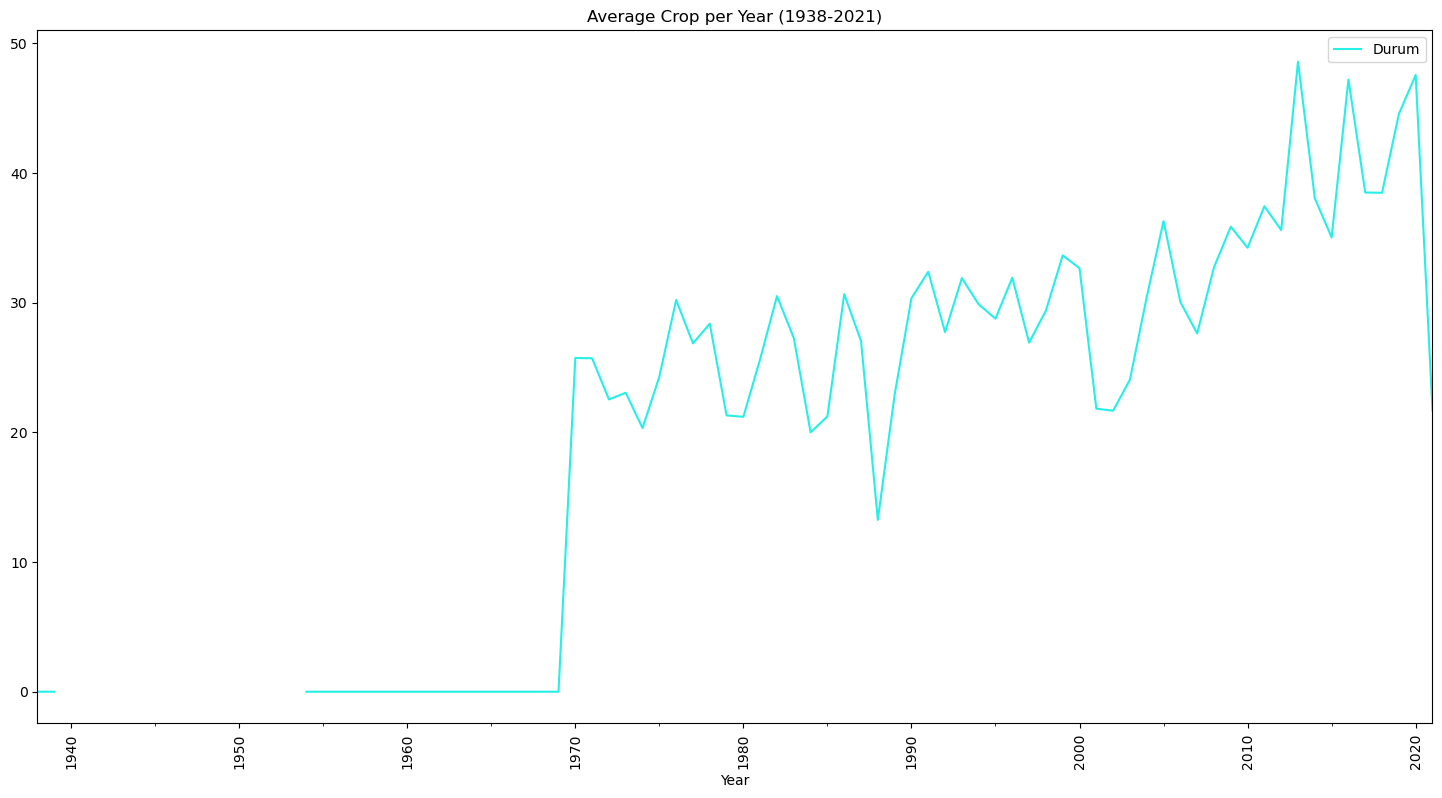

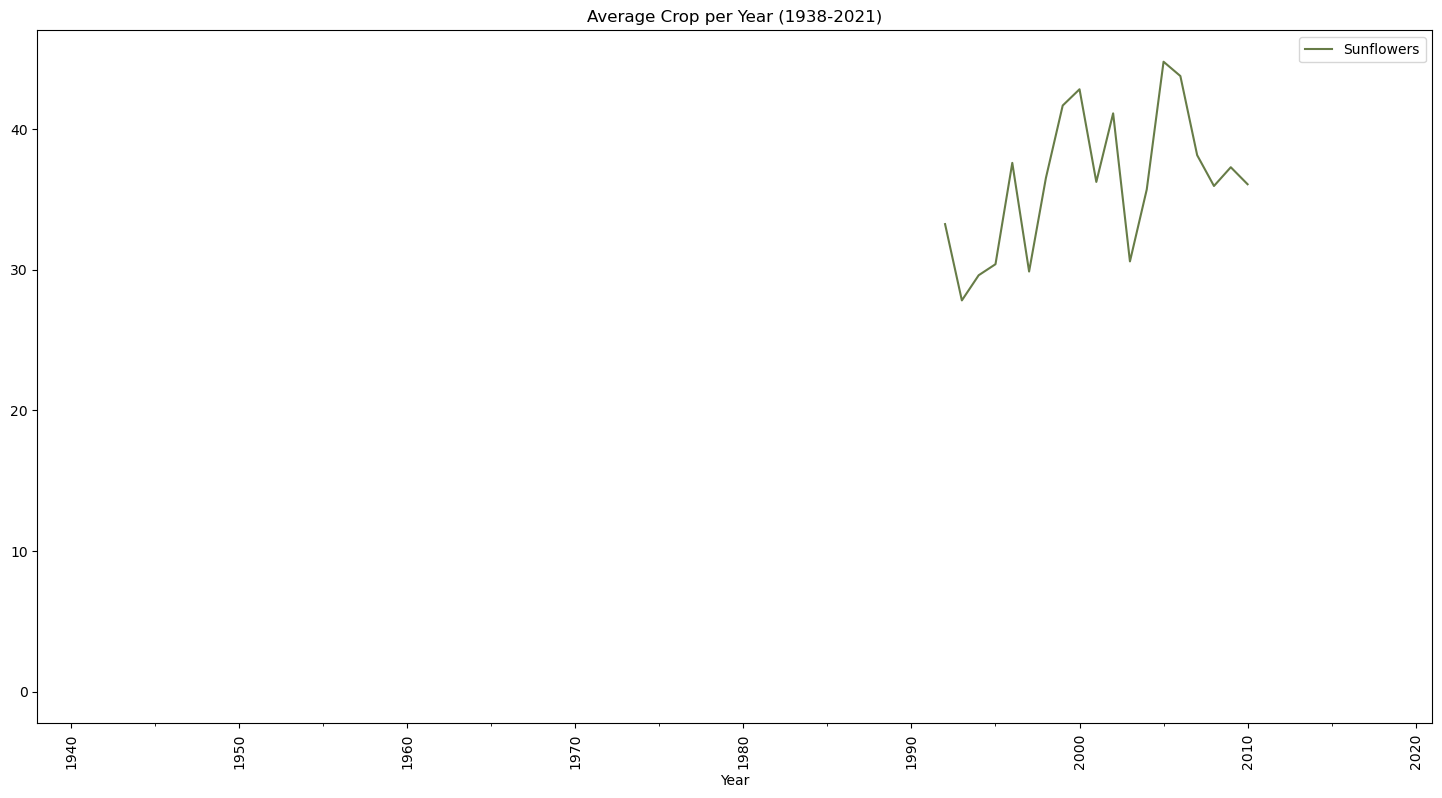

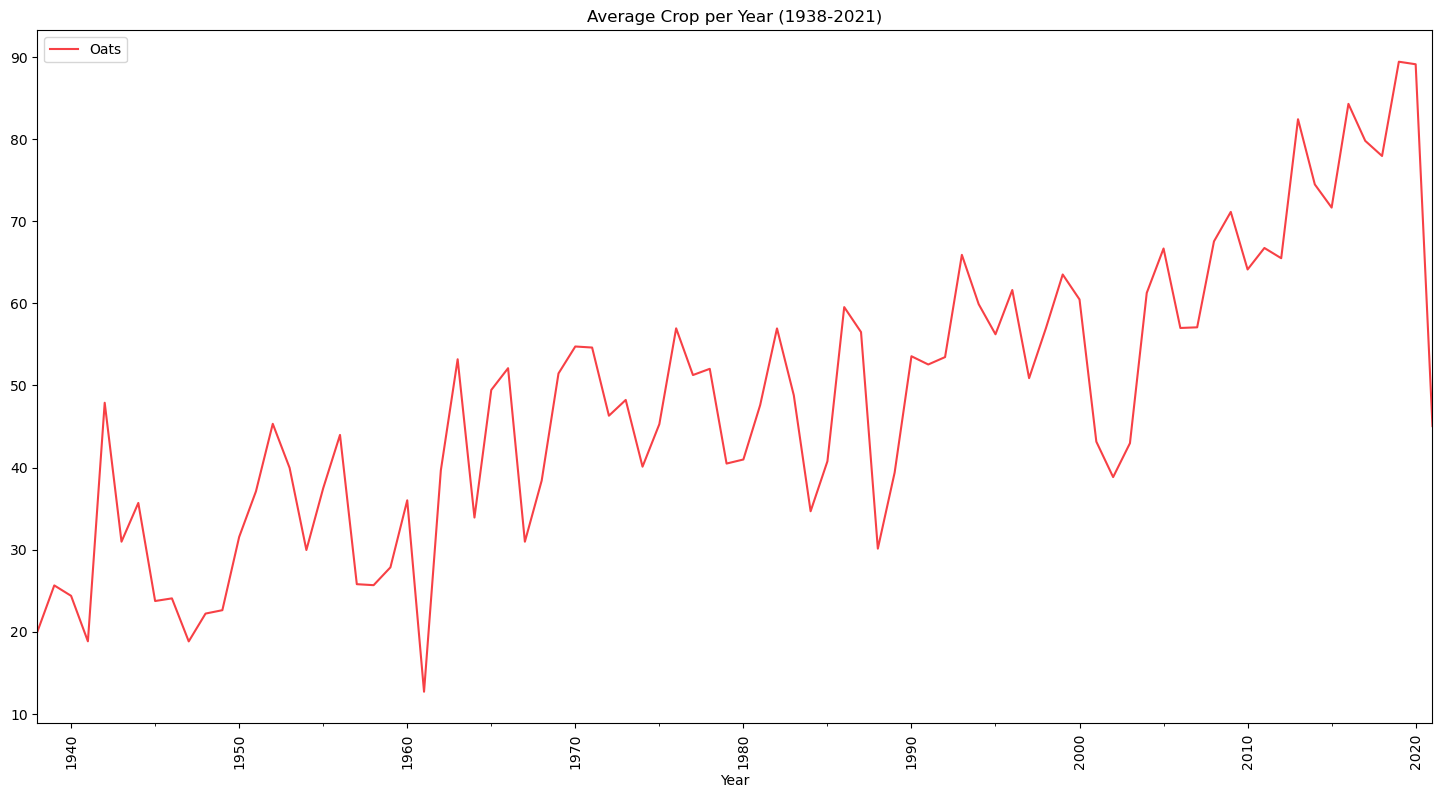

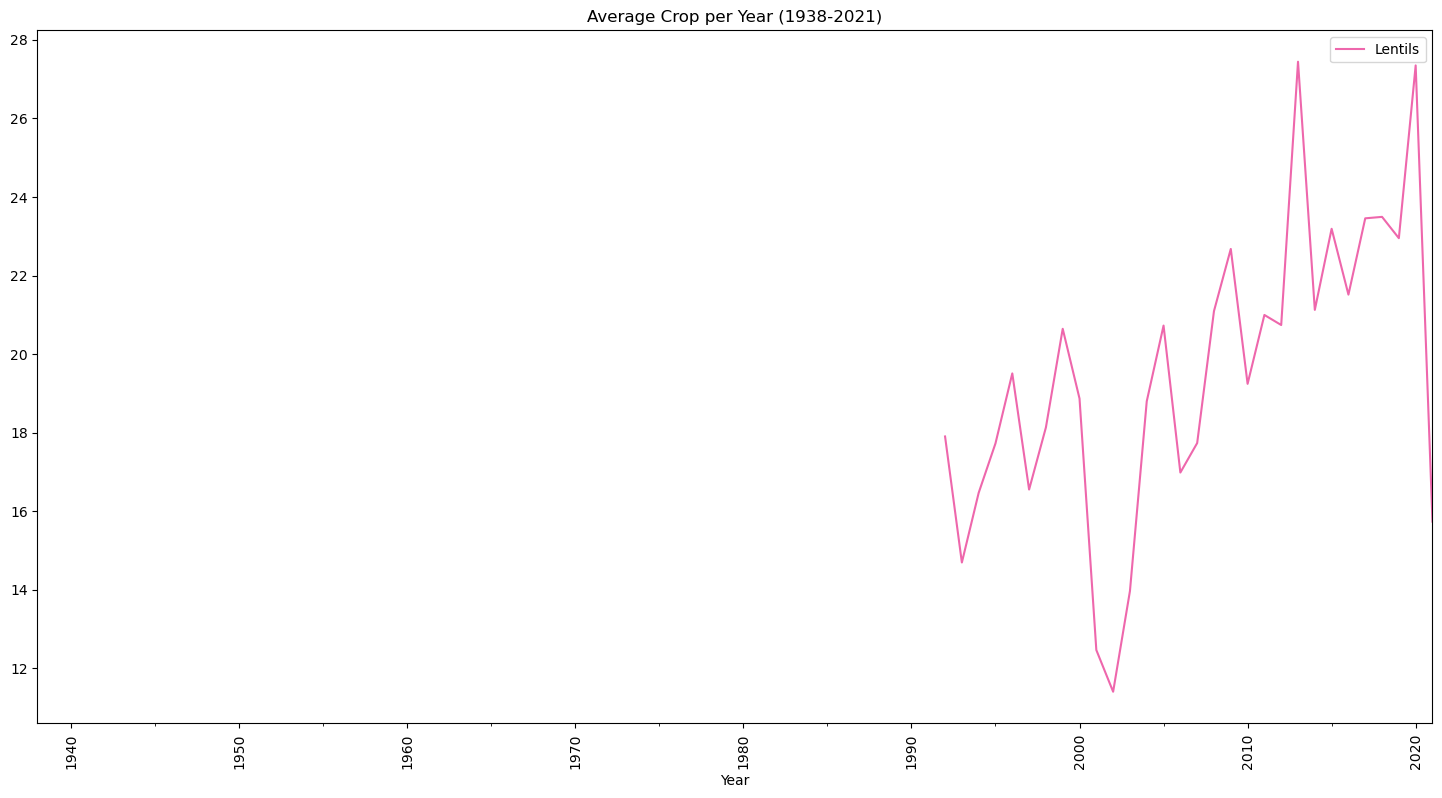

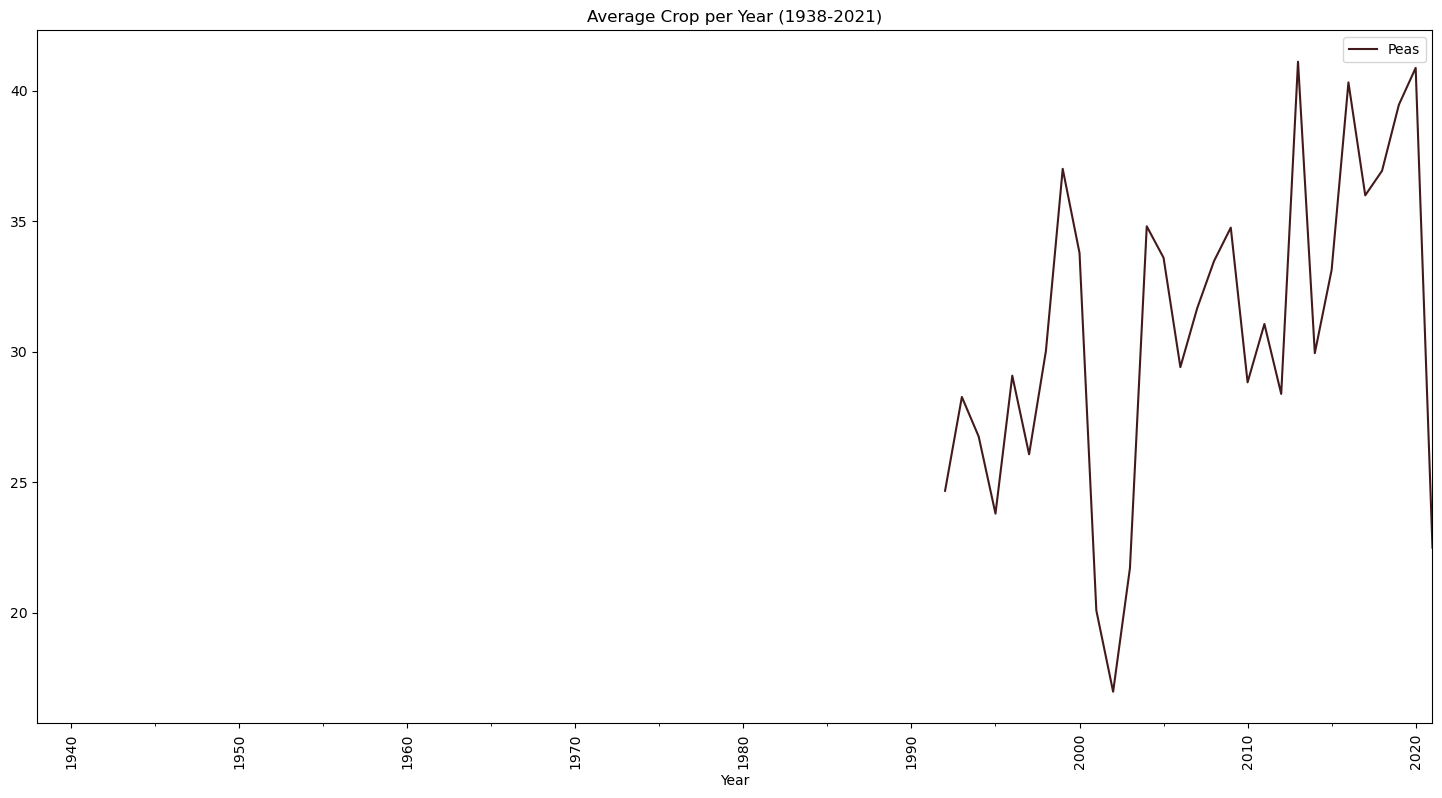

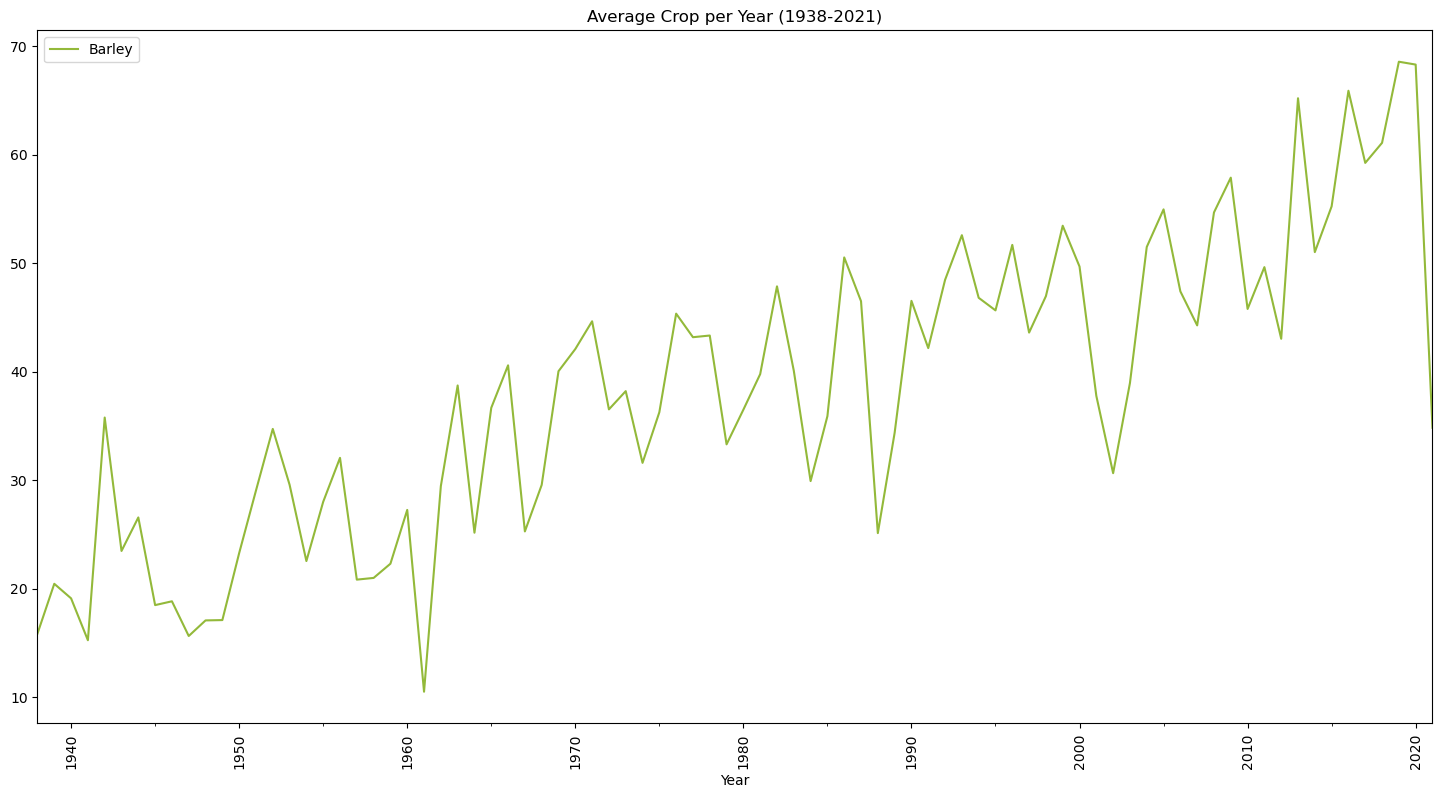

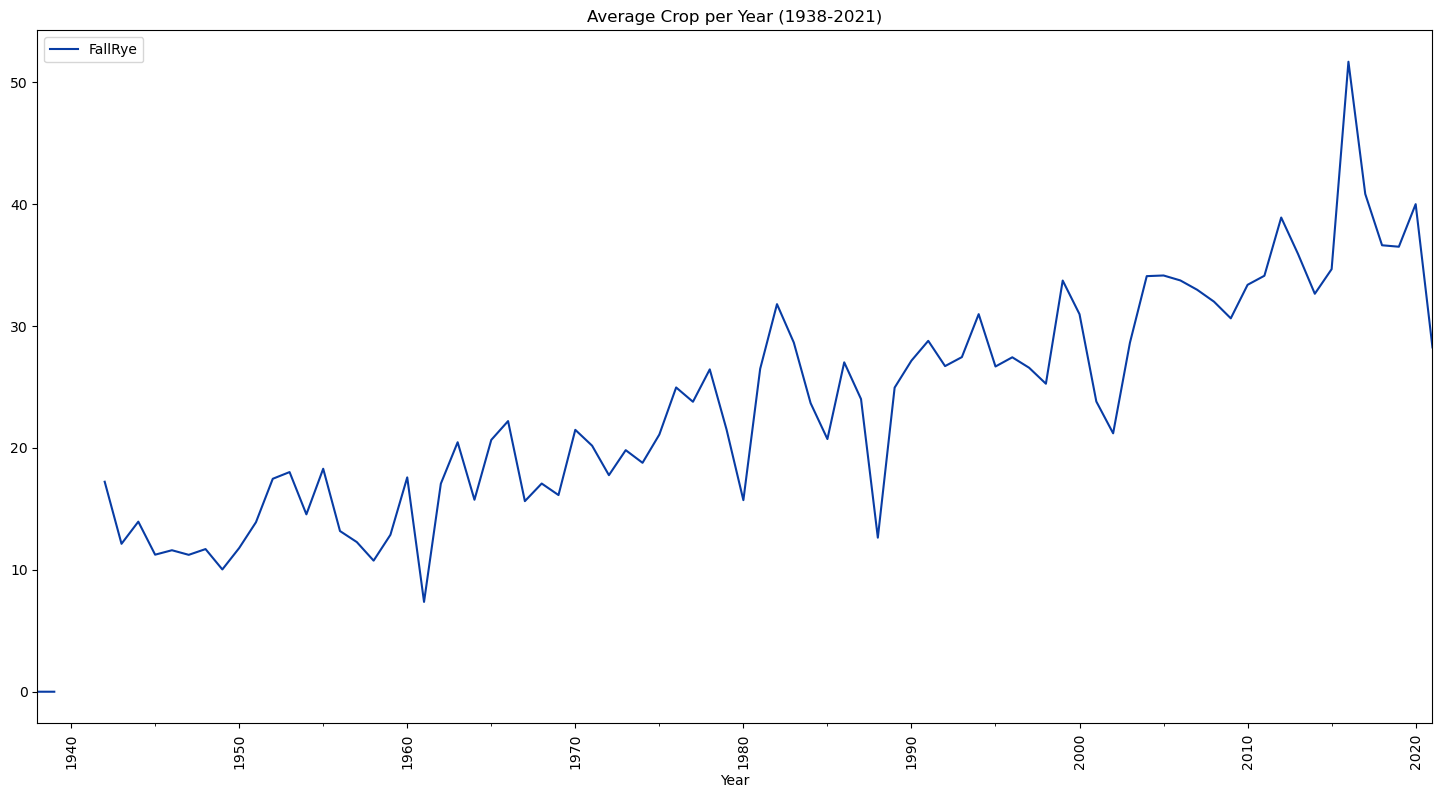

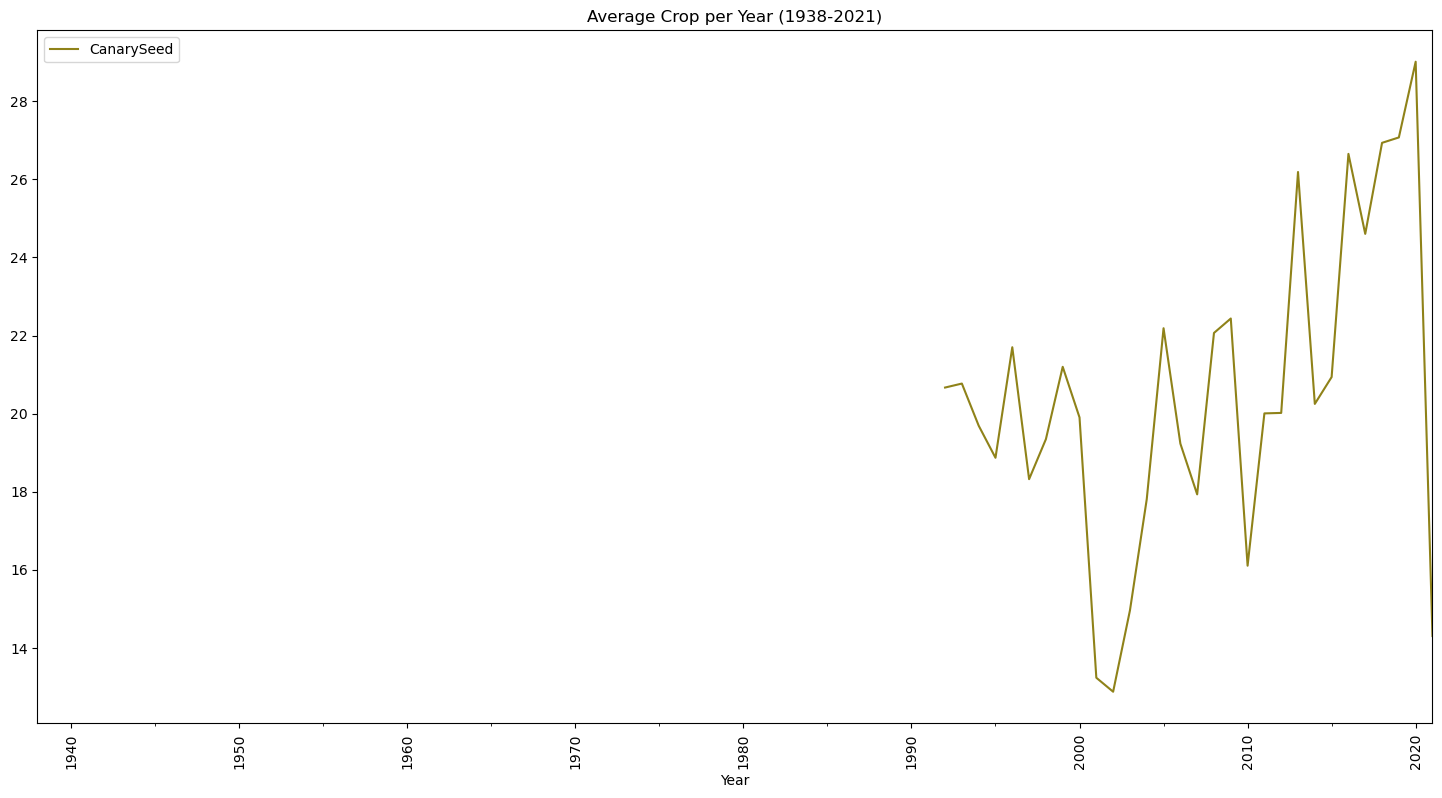

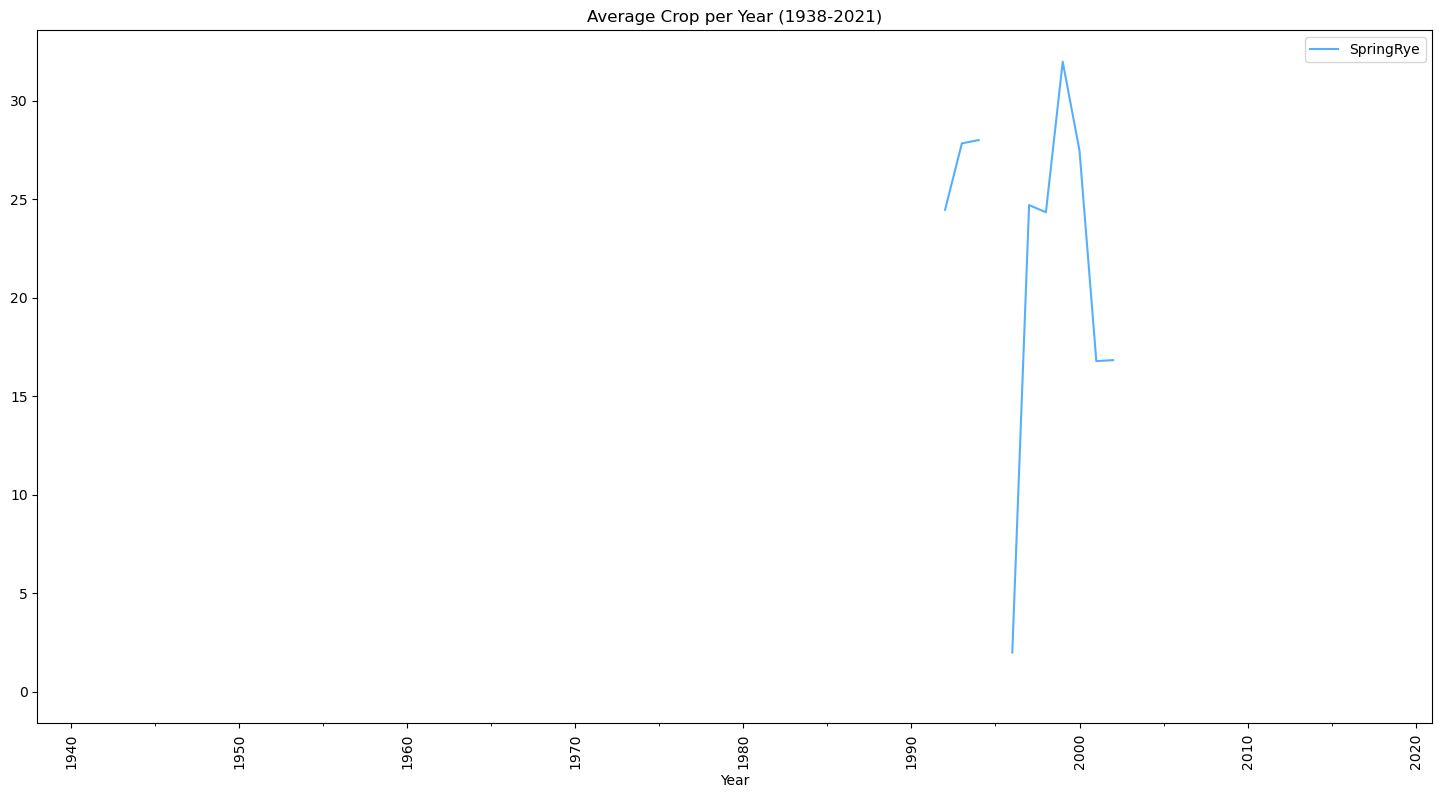

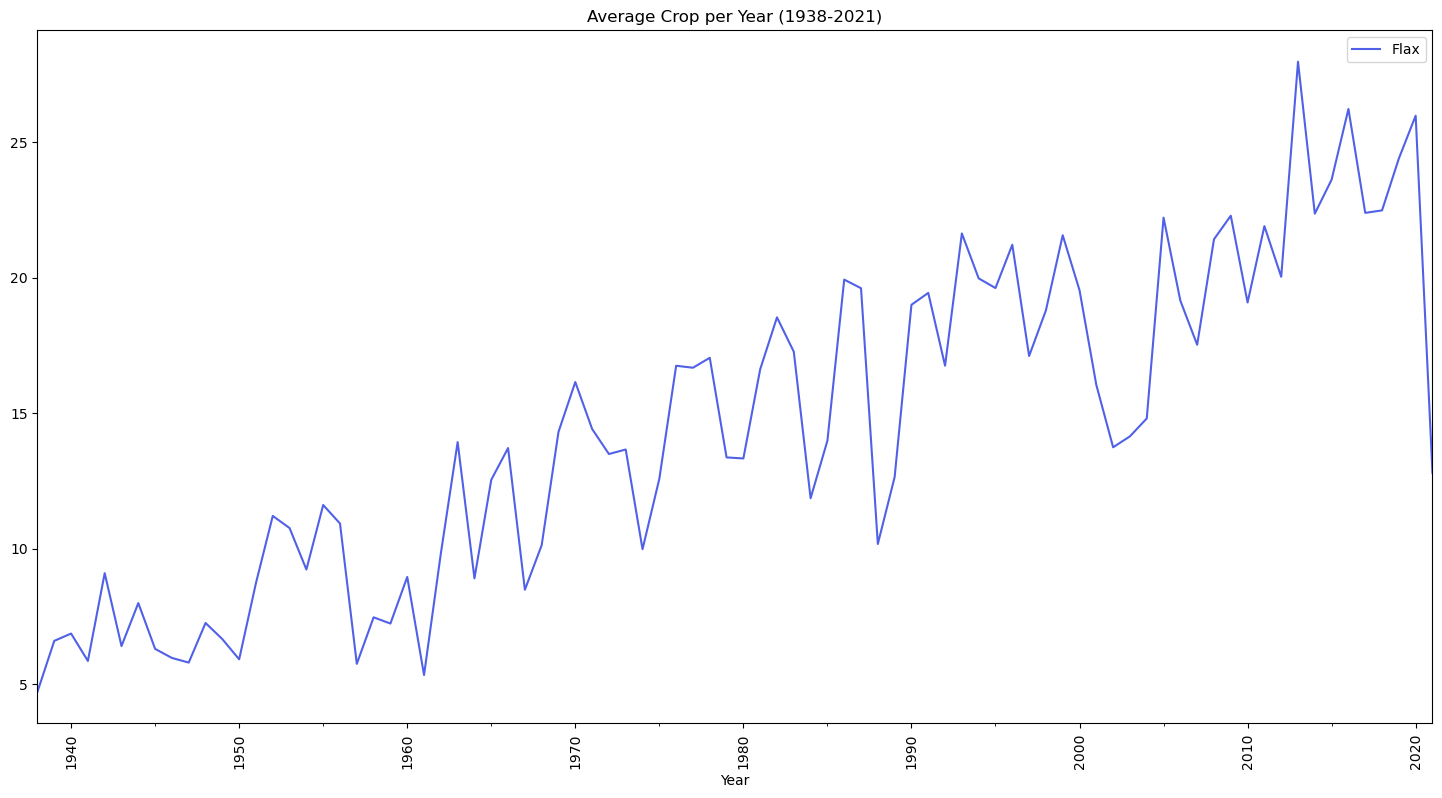

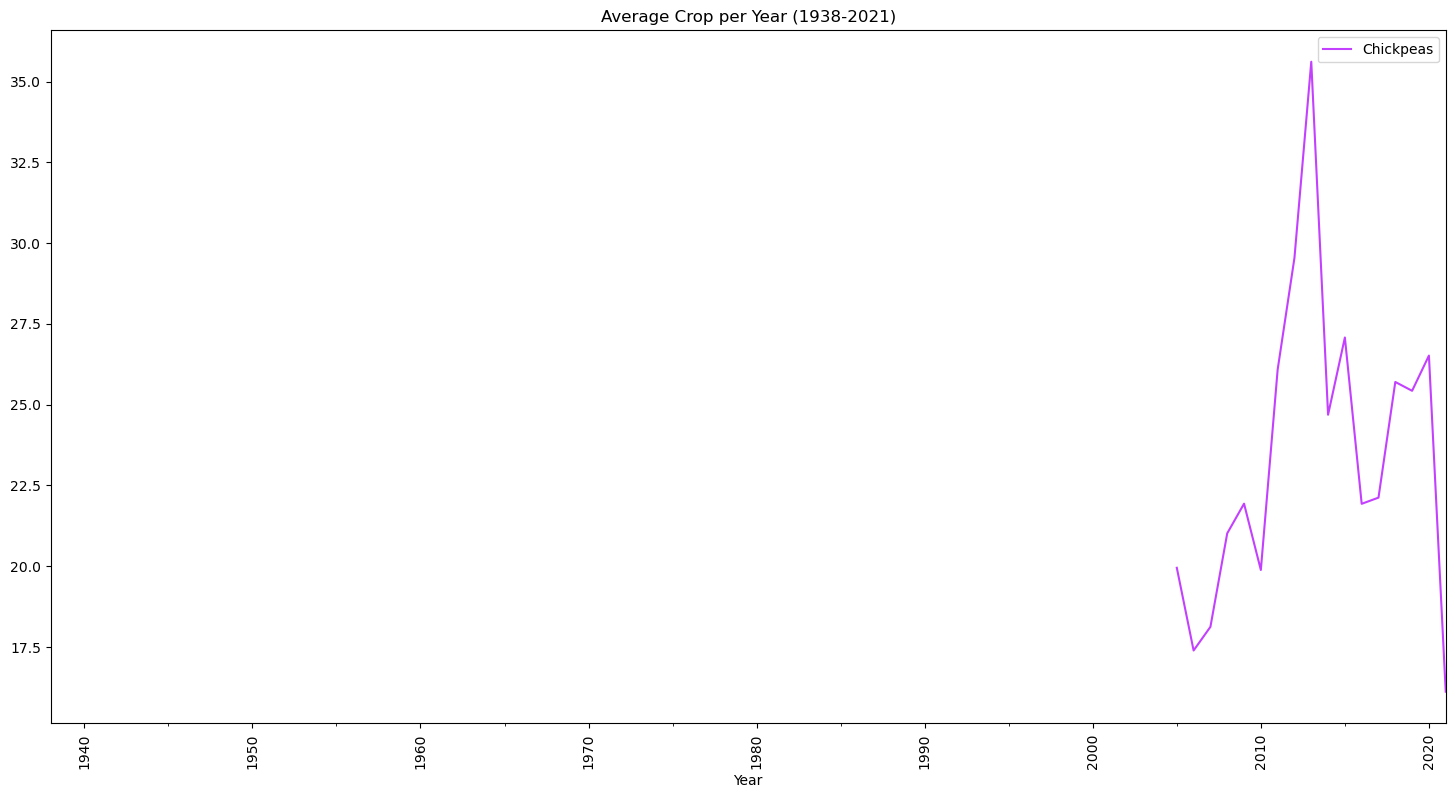

In [20]:
temp_df= df_csv.copy()
temp_df['Year'] = pd.to_datetime(temp_df['Year'], format='%Y')
temp_df= temp_df.groupby('Year').mean().copy()
temp_df.drop(['RM'],axis=1,inplace=True)

for i in temp_df.columns:
    temp_df[i].plot(title='Average Crop per Year (1938-2021)',color=np.random.random(3),figsize=(18,9))
    plt.xticks(rotation='vertical')
    plt.legend()
    plt.savefig(i+'.jpg',bbox_inches='tight')
    plt.show()

# Feature Selection

<AxesSubplot:>

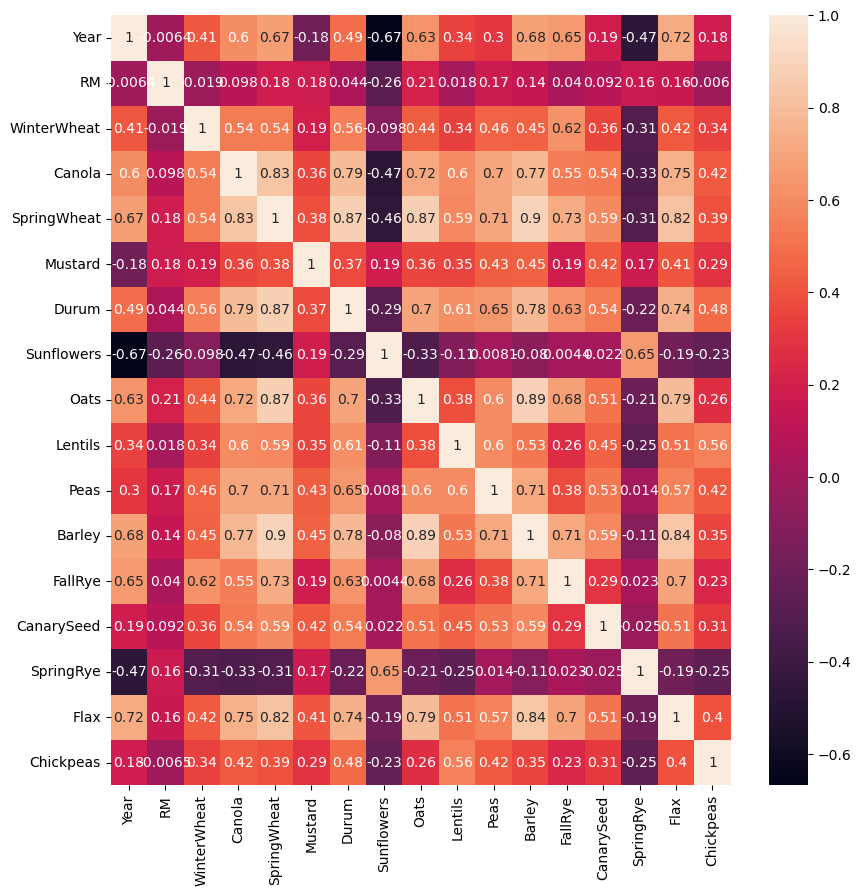

In [21]:
plt.rcParams['figure.figsize'] = (10, 10)
sb.heatmap(
    df_csv.corr(),
    annot=True)
#Strong correlation between:
#Canola: Spring Wheat, Durum, Oats, Peas, Barley, Flax
#Spring Wheat: Barley, Canola, Durum, Oats, Flax
#Durum: Spring Wheat, Barley, Flax
#Sunflower: Tame Hay
#Oats: Spring Wheat, Durumn, Barley, Flax
#Peas: Canola, Spring Wheat, Barley
#Barley: Oats, Canola, Spring Wheat, Barley, Fall Rye, Flax
#Fall Rye: Spring Wheat, Barley, Flax
#Tame Hay: Sunflowers
#Flax: Spring Wheat, Oats, Barley, Canola, Durum

<AxesSubplot:ylabel='Count of missing values (1938-2021)'>

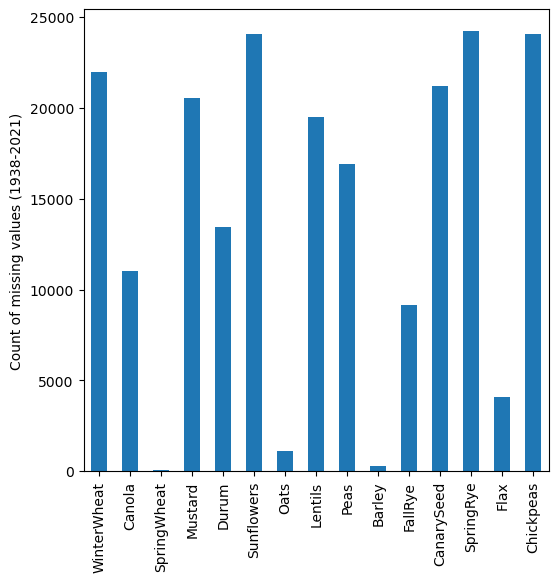

In [22]:
df_csv.iloc[:,2:18].isna().sum().plot(kind='bar',ylabel='Count of missing values (1938-2021)',figsize=(6,6))

# K-Means Clustering

In [23]:
from sklearn.cluster import KMeans

def call_ElbowMethod(df_meanstd):

# Define the features to be used for clustering
    X = df_meanstd[['MeanYield', 'StdYield']]

# Elbow method to determine the optimal number of clusters
    sse = []
    for k in range(1, 12):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
    
# Plot the elbow graph
    plt.plot(range(1, 12), sse)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Squared Distances')
    plt.show()
    
    return X

In [24]:
def call_KMeans(kcluster,X):

# Fit the KMeans model with the optimal number of clusters
    kmeans = KMeans(n_clusters=kcluster)
    kmeans.fit(X)

# Predict the cluster labels for each data point
    labels = kmeans.predict(X)

# Plot the data points and cluster centers
    plt.scatter(X['MeanYield'], X['StdYield'], c=labels)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=200, linewidths=3, color='r')
    plt.xlabel('MeanYield')
    plt.ylabel('StdYield')
    plt.show()
    
    return labels

In [25]:
def showClusterMap(kcluster,croptype):

    m=pd.merge(
        gdf[['RM', 'Municipality', 'geometry']],
        df_ms,
        on='RM'
        ).explore(
        column='Labels', # column you want to visualize
        cmap='YlGn', # color on the map
        k=kcluster, # number of colors. We have 3 clusters
        scheme='naturalbreaks', #How your legened will look like
        tiles='Stamen Terrain', # map background type
        tooltip=['Municipality', 'MeanYield'] # what to show when you hover around your mouse
    )
#    m.save("Clustering_"+croptype+".html")
    return m

## RM 429

In [26]:
#df_one_RM = gdf[gdf['RM']==429].copy()
#df_one_RM['geometry'] = df_one_RM['geometry'].centroid

#df_one_RM = df_one_RM.to_crs(gdf.crs)
df_RM_429 = gdf[gdf['RM']==429].copy()

## Clustering Spring Wheat 

In [27]:
new_df = df_csv[['Year','RM','SpringWheat']].copy()
new_df

,Year,RM,SpringWheat
0,1938,1,4.00
1,1939,1,9.00
2,1940,1,12.00
3,1941,1,18.00
4,1942,1,20.00
...,...,...,...
25012,2017,622,59.49
25013,2018,622,59.50
25014,2019,622,63.90
25015,2020,622,55.10


In [28]:
new_df.isna().sum()

Year            0
RM              0
SpringWheat    93
dtype: int64

In [29]:
new_df[new_df['SpringWheat'].isna()].groupby('RM').count()

,Year,SpringWheat
RM,,
1,1,0
2,1,0
7,2,0
9,5,0
10,3,0
11,5,0
12,1,0
17,1,0
39,2,0


In [30]:
new_df[new_df['SpringWheat'].isna()].groupby('Year').count()

,RM,SpringWheat
Year,,
1938,4,0
1939,4,0
1940,1,0
1973,1,0
1978,2,0
1987,1,0
1988,1,0
1989,1,0
1990,1,0


In [31]:
temp_df = new_df[new_df['RM']==555]
temp_df[temp_df['SpringWheat'].isna()]

,Year,RM,SpringWheat
24682,1938,555,NaN
24683,1939,555,NaN
24717,1973,555,NaN
24722,1978,555,NaN
24738,1994,555,NaN
24744,2000,555,NaN
24745,2001,555,NaN
24749,2005,555,NaN
24750,2006,555,NaN
24751,2007,555,NaN


In [32]:
gdf[gdf['RM']==555]

,RM,Municipality,geometry
230,555,BIG RIVER,"POLYGON ((382623.457 5977383.405, 382824.163 5..."


In [33]:
df_mean=new_df.groupby(['RM'])['SpringWheat'].mean()\
    .to_frame()

In [34]:
df_std=new_df.groupby(['RM'])['SpringWheat'].std()\
    .to_frame()

In [36]:
df_ms=pd.merge(
    df_mean.rename(columns={'SpringWheat': 'MeanYield'}),
    df_std.rename(columns={'SpringWheat': 'StdYield'}),
    on='RM'
)

<AxesSubplot:>

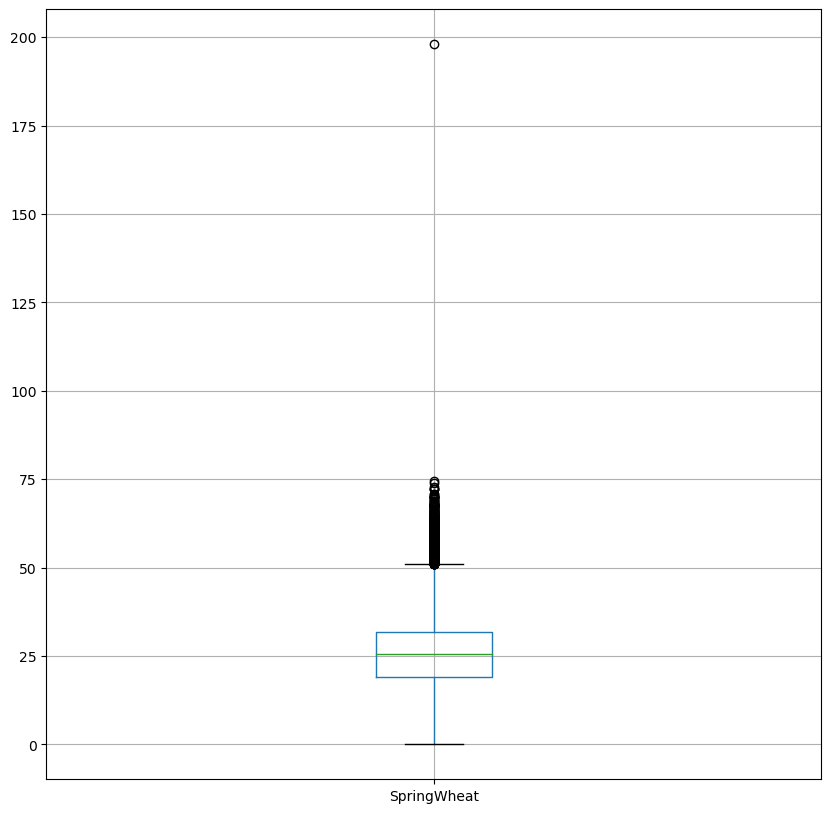

In [41]:
new_df.boxplot(column=['SpringWheat'])

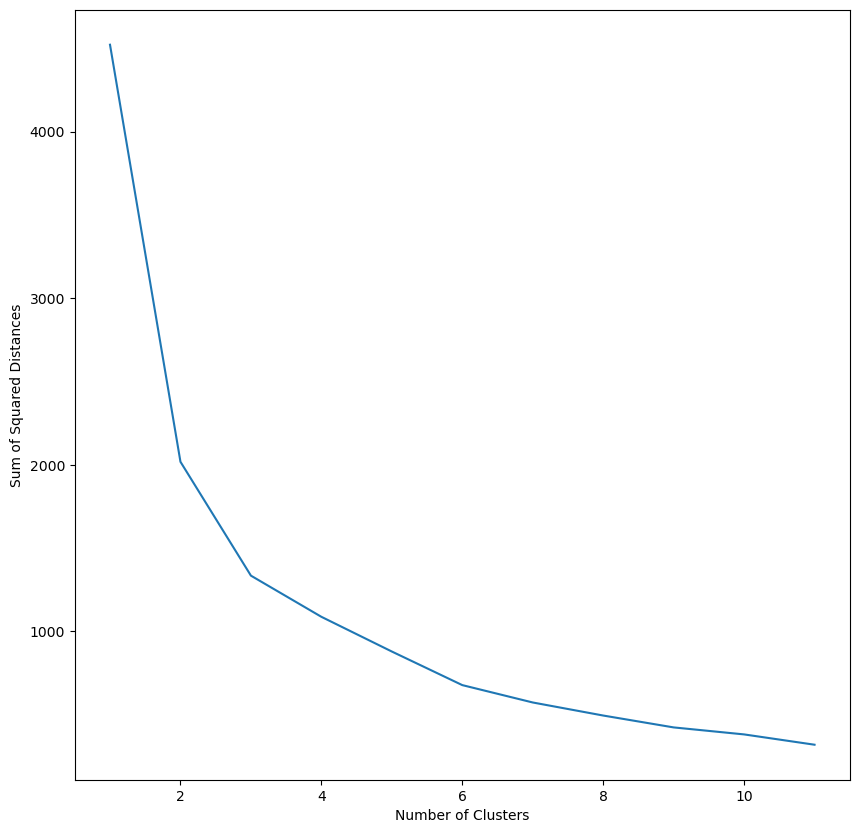

In [762]:
cluster_X = call_ElbowMethod(df_ms)

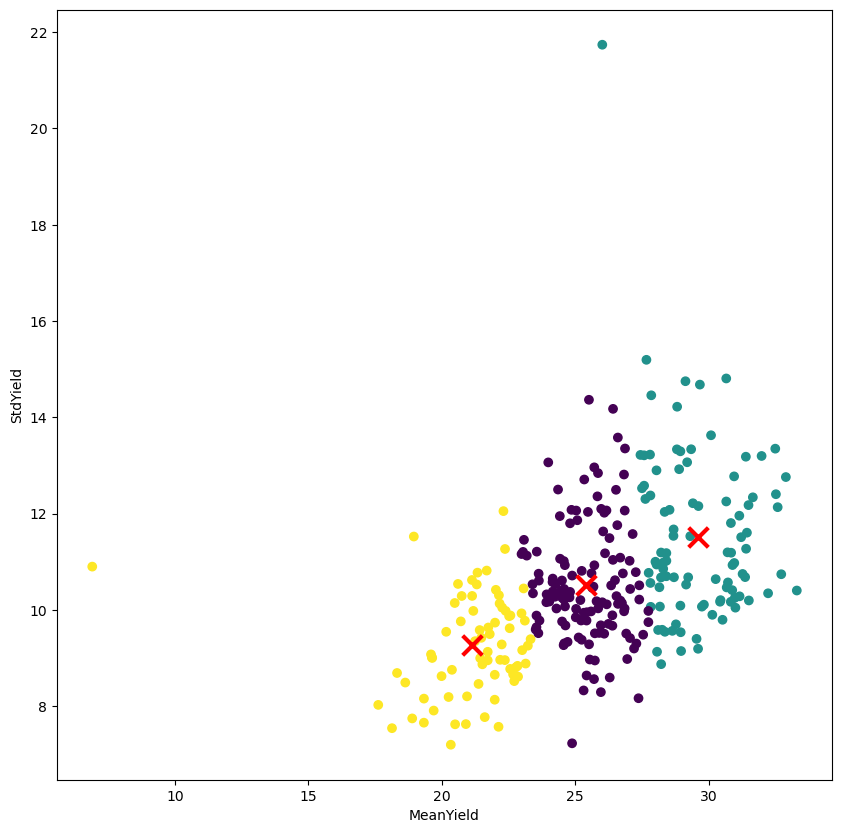

In [763]:
df_ms['Labels']=call_KMeans(3,cluster_X)

In [764]:
df_ms.groupby('Labels').mean()\
    .sort_values('MeanYield')

,MeanYield,StdYield
Labels,,
2,21.135842,9.264871
0,25.414199,10.521565
1,29.608589,11.522007


In [765]:
df_ms.replace(to_replace={
    0:1,
    1:2,
    2:0}, inplace=True
)

In [766]:
m=showClusterMap(3,'SpringWheat')

In [767]:
n=df_one_RM.explore(m=m)
n.save("XClustering_SpringWheat.html")

## Clustering Barley

In [822]:
new_df = df_csv[['Year','RM','Barley']].copy()
new_df

,Year,RM,Barley
0,1938,1,1.0
1,1939,1,16.0
2,1940,1,19.0
3,1941,1,28.0
4,1942,1,28.0
...,...,...,...
25012,2017,622,NaN
25013,2018,622,54.0
25014,2019,622,73.9
25015,2020,622,74.3


In [823]:
new_df.isna().sum()

Year        0
RM          0
Barley    314
dtype: int64

In [824]:
new_df[new_df['Barley'].isna()].groupby('RM').count()

,Year,Barley
RM,,
1,1,0
5,3,0
6,3,0
7,9,0
8,10,0
...,...,...
529,5,0
555,22,0
561,17,0


In [825]:
new_df[new_df['Barley'].isna()].groupby('Year').count()

,RM,Barley
Year,,
1938,10,0
1939,7,0
1940,3,0
1941,3,0
1942,5,0
1943,6,0
1944,5,0
1945,5,0
1946,2,0


In [826]:
df_mean=new_df.groupby(['RM'])['Barley'].mean()\
    .to_frame()

In [827]:
df_std=new_df.groupby(['RM'])['Barley'].std()\
    .to_frame()

In [828]:
df_ms=pd.merge(
    df_mean.rename(columns={'Barley': 'MeanYield'}),
    df_std.rename(columns={'Barley': 'StdYield'}),
    on='RM'
)

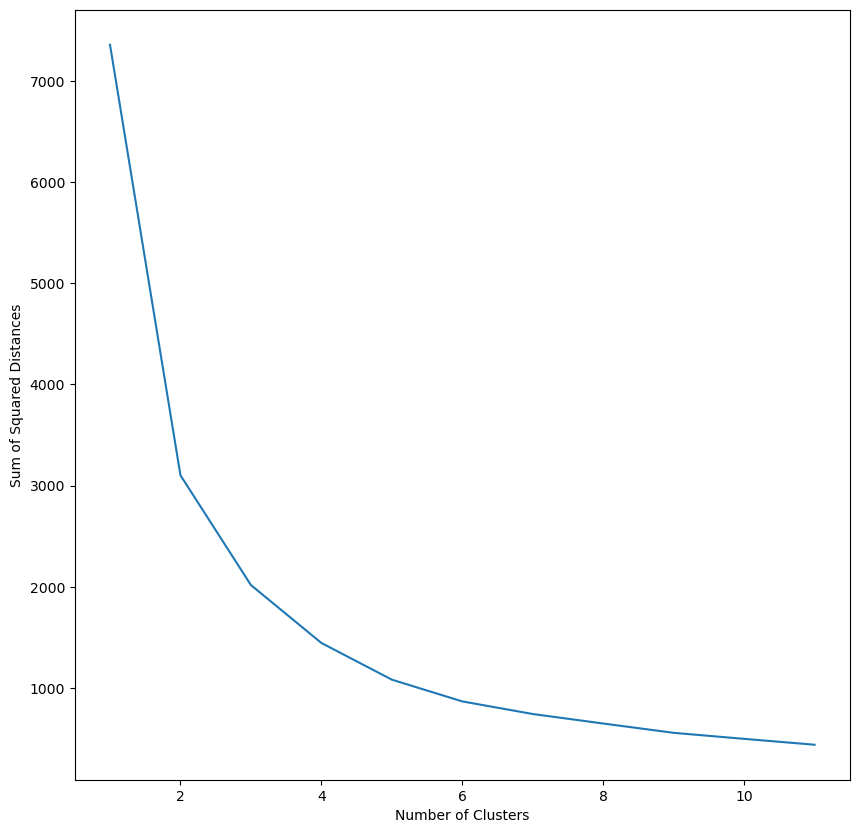

In [829]:
cluster_X = call_ElbowMethod(df_ms)

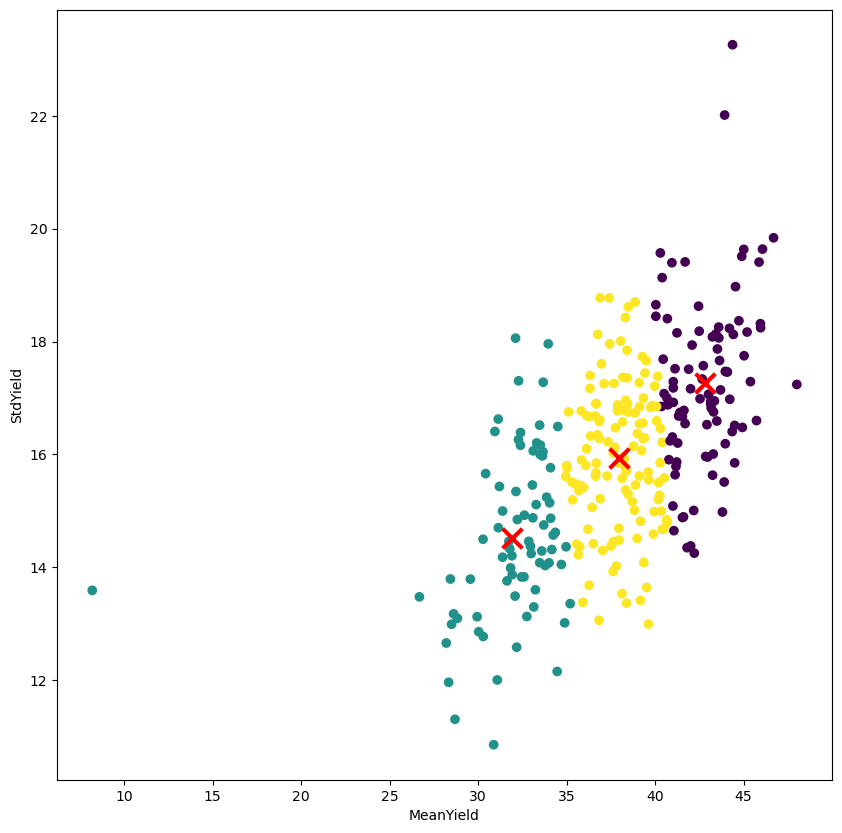

In [830]:
df_ms['Labels']=call_KMeans(3,cluster_X)

In [831]:
df_ms.groupby('Labels').mean()\
    .sort_values('MeanYield')

,MeanYield,StdYield
Labels,,
1,31.918015,14.512165
2,37.965076,15.933481
0,42.838850,17.257355


In [832]:
df_ms.replace(to_replace={
    1:0,
    2:1,
    0:2}, inplace=True
)

In [833]:
m=showClusterMap(3,'Barley')

n=df_one_RM.explore(m=m)
n.save("XClustering_Barley.html")

## Clustering Oats

In [780]:
new_df = df_csv[['Year','RM','Oats']].copy()
new_df

,Year,RM,Oats
0,1938,1,1.00
1,1939,1,16.00
2,1940,1,23.00
3,1941,1,32.00
4,1942,1,35.00
...,...,...,...
25012,2017,622,93.01
25013,2018,622,96.40
25014,2019,622,106.00
25015,2020,622,94.50


In [781]:
new_df.isna().sum()

Year       0
RM         0
Oats    1104
dtype: int64

In [782]:
new_df[new_df['Oats'].isna()].groupby('RM').count()

,Year,Oats
RM,,
4,3,0
5,9,0
6,8,0
7,12,0
8,4,0
...,...,...
521,5,0
529,1,0
555,15,0


In [783]:
new_df[new_df['Oats'].isna()].groupby('Year').count()

,RM,Oats
Year,,
1938,4,0
1939,4,0
1940,2,0
1941,2,0
1942,4,0
1943,7,0
1944,5,0
1945,3,0
1946,3,0


In [784]:
df_mean=new_df.groupby(['RM'])['Oats'].mean()\
    .to_frame()

In [785]:
df_std=new_df.groupby(['RM'])['Oats'].std()\
    .to_frame()

In [786]:
df_ms=pd.merge(
    df_mean.rename(columns={'Oats': 'MeanYield'}),
    df_std.rename(columns={'Oats': 'StdYield'}),
    on='RM'
)

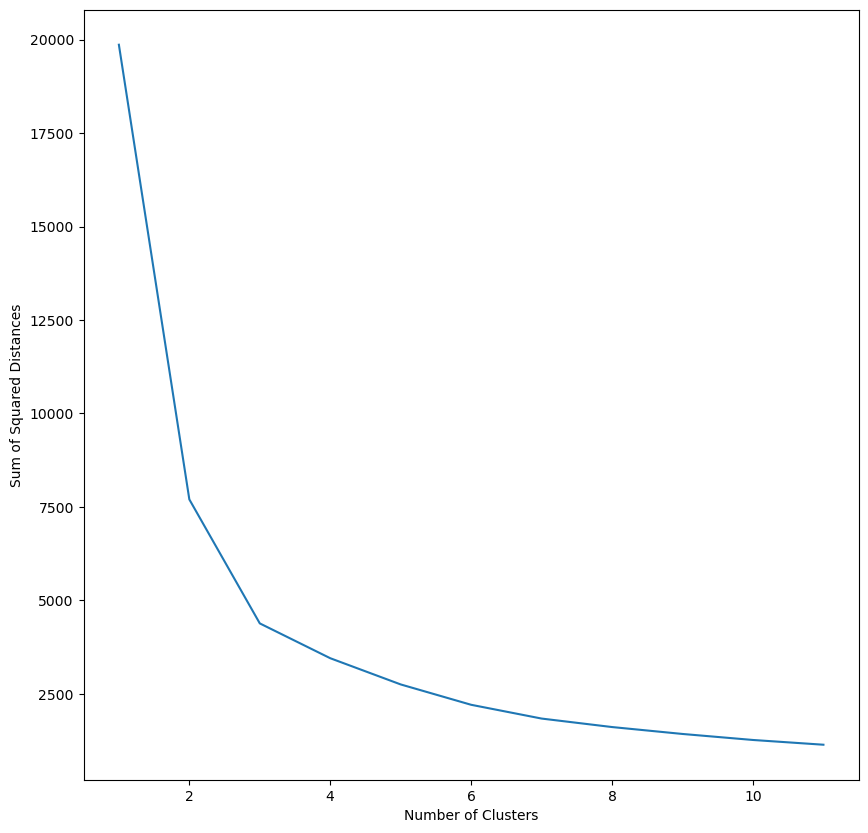

In [787]:
cluster_X = call_ElbowMethod(df_ms)

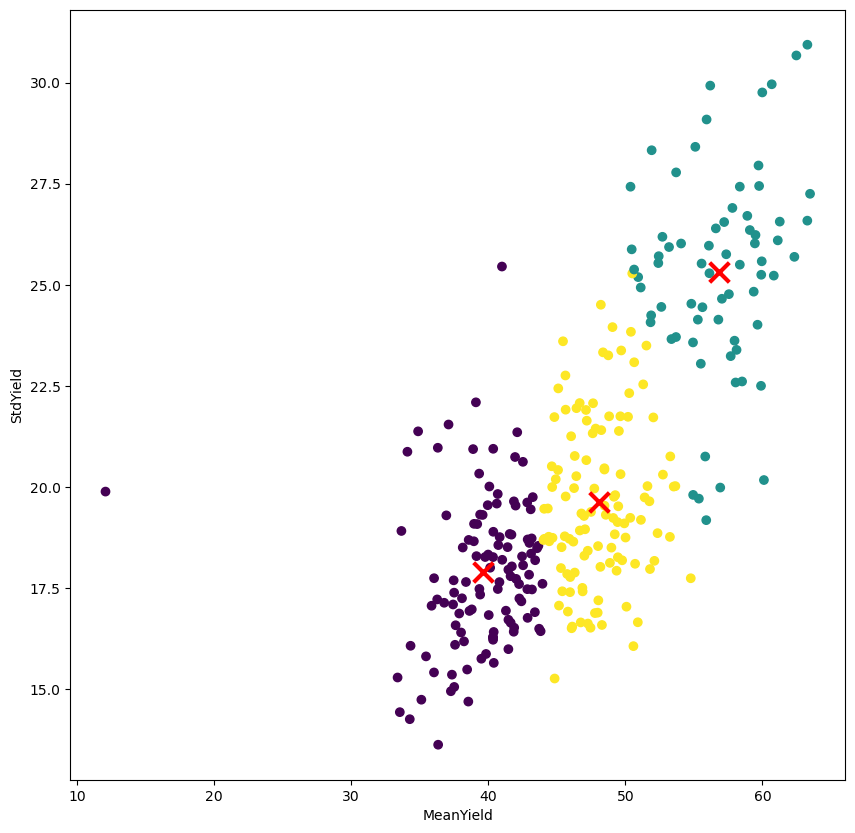

In [788]:
df_ms['Labels']=call_KMeans(3,cluster_X)

In [789]:
df_ms.groupby('Labels').mean()\
    .sort_values('MeanYield')

,MeanYield,StdYield
Labels,,
0,39.582480,17.890189
2,48.100723,19.641220
1,56.793767,25.321321


In [790]:
df_ms.replace(to_replace={
    2:1,
    1:2}, inplace=True
)

In [791]:
m=showClusterMap(3,'Oats')

n=df_one_RM.explore(m=m)
n.save("XClustering_Oats.html")

## Clustering Canola

In [807]:
new_df = df_csv[['Year','RM','Canola']].copy()

In [808]:
new_df.isna().sum()

Year          0
RM            0
Canola    11009
dtype: int64

In [809]:
new_df = new_df[new_df['Year']>=2001]

In [810]:
new_df.isna().sum()

Year        0
RM          0
Canola    260
dtype: int64

In [811]:
new_df.count()

Year      6201
RM        6201
Canola    5941
dtype: int64

In [812]:
new_df[new_df['Canola'].isna()].groupby('RM').count()

,Year,Canola
RM,,
8,3,0
9,8,0
11,3,0
17,8,0
18,15,0
...,...,...
470,8,0
496,1,0
498,1,0


In [813]:
new_df[new_df['Canola'].isna()].groupby('Year').count()

,RM,Canola
Year,,
2001,20,0
2002,38,0
2003,14,0
2004,12,0
2005,20,0
2006,22,0
2007,19,0
2008,33,0
2009,31,0


In [814]:
df_mean=new_df.groupby(['RM'])['Canola'].mean()\
    .to_frame()

In [815]:
df_std=new_df.groupby(['RM'])['Canola'].std()\
    .to_frame()

In [816]:
df_ms=pd.merge(
    df_mean.rename(columns={'Canola': 'MeanYield'}),
    df_std.rename(columns={'Canola': 'StdYield'}),
    on='RM'
)

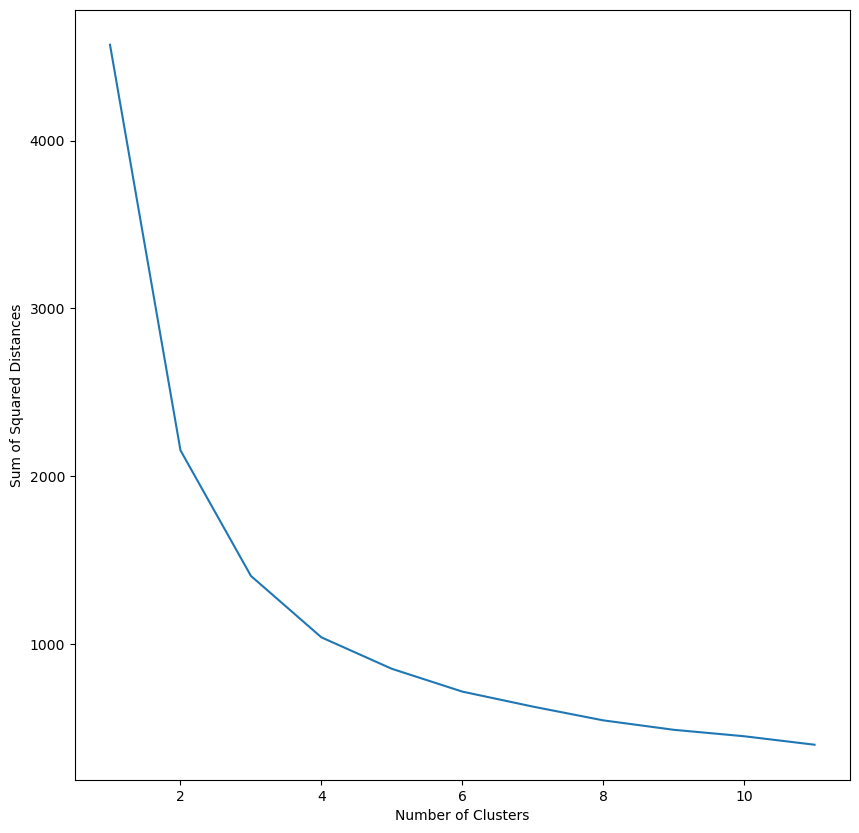

In [817]:
cluster_X = call_ElbowMethod(df_ms)

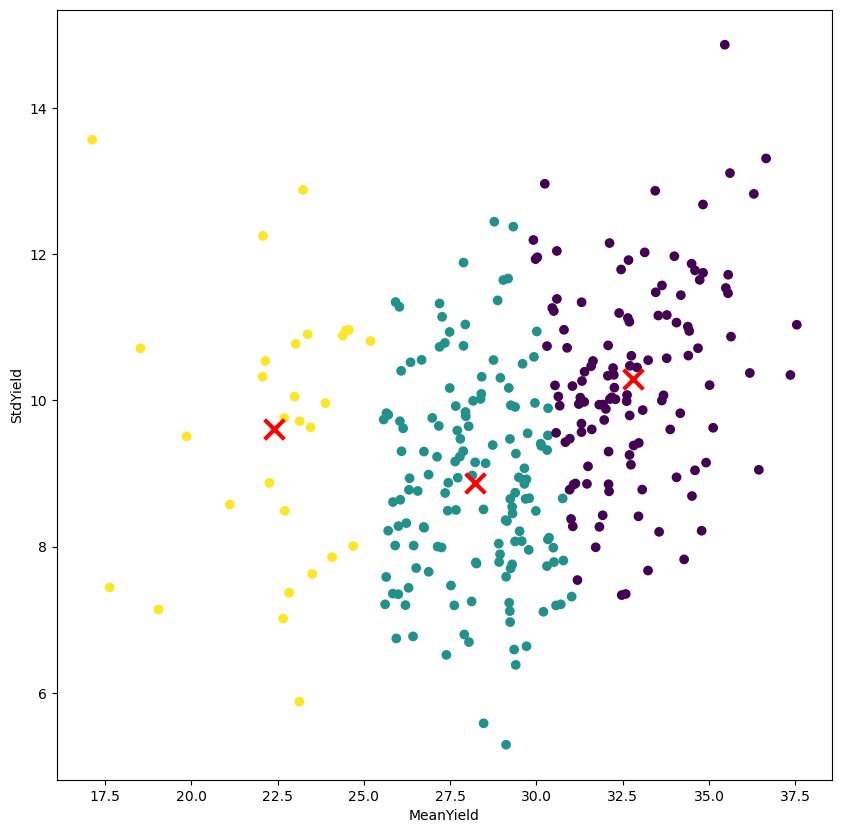

In [818]:
df_ms['Labels']=call_KMeans(3,cluster_X)

In [819]:
df_ms.groupby('Labels').mean()\
    .sort_values('MeanYield')

,MeanYield,StdYield
Labels,,
2,22.412488,9.602729
1,28.218506,8.870589
0,32.810171,10.295132


In [820]:
df_ms.replace(to_replace={
    0:2,
#    1:2,
    2:0}, inplace=True
)

In [821]:
m=showClusterMap(3,'Canola')
n=df_RM_429.explore(m=m)
n.save("XClustering_Canola.html")
